<a href="https://colab.research.google.com/github/pinkesh-ai/DL201/blob/main/PinAi21_04_mnist_full_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 30.8MB/s 
     |████████████████████████████████| 1.2MB 38.1MB/s 
     |████████████████████████████████| 204kB 53.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Load full MNIST dataset

We are try to rerun the two classifiers built before to classify images as a 3 or a 7, but using the full dataset with 10 digits. So let's download the full MNIST datasets:

In [ ]:
path = untar_data(URLs.MNIST)    # Full dataset (0s to 9s)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
(path/'training').ls()

(#10) [Path('training/2'),Path('training/0'),Path('training/8'),Path('training/7'),Path('training/3'),Path('training/6'),Path('training/5'),Path('training/1'),Path('training/4'),Path('training/9')]

There's a folder for each digit from 0s to 9s. Let's take a look in one of these folders 
``` python
    paths_dict = {0: [list of the paths to images of 0],
                  1: [list of the paths to images of 1],

                  i: [list of the paths to images of i],

                  9: [list of the paths to images of 9],
                 }
```

In [ ]:
paths_dict = {}         # Create an empty dictionary to hold the paths list for each digit
for i in range(10):
    paths_dict[i] = (path/'training'/f"{i}").ls().sorted()   # add the list of path for digit i to the dict

paths_dict

{0: (#5923) [Path('training/0/1.png'),Path('training/0/1000.png'),Path('training/0/10005.png'),Path('training/0/10010.png'),Path('training/0/10022.png'),Path('training/0/10025.png'),Path('training/0/10026.png'),Path('training/0/10045.png'),Path('training/0/10069.png'),Path('training/0/10071.png')...],
 1: (#6742) [Path('training/1/10006.png'),Path('training/1/10007.png'),Path('training/1/1002.png'),Path('training/1/10020.png'),Path('training/1/10027.png'),Path('training/1/1003.png'),Path('training/1/10040.png'),Path('training/1/10048.png'),Path('training/1/10058.png'),Path('training/1/10067.png')...],
 2: (#5958) [Path('training/2/10009.png'),Path('training/2/10016.png'),Path('training/2/10024.png'),Path('training/2/10029.png'),Path('training/2/10072.png'),Path('training/2/10073.png'),Path('training/2/10075.png'),Path('training/2/10078.png'),Path('training/2/10081.png'),Path('training/2/10082.png')...],
 3: (#6131) [Path('training/3/10.png'),Path('training/3/10000.png'),Path('training/

Let’s take a look at one image for each of the digits:

In [ ]:
for i in range(10):
    img_paths = paths_dict[i][3]
    img = Image.open(img_paths)
    display(img)

We can store the image in a tensor and slice it to pick some part of the image. We then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

## Baseline model: Pixel Similarity

Step one for our simple model is to get the average of pixel values for the groups of images for each pixel.

Let's create a tensor containing all of the images representing a single digit, stacked together.

In [ ]:
tensors_dict = {}
for i in range(10):
    tensors_dict[i] = [tensor(Image.open(o)) for o in paths_dict[i]]

In [ ]:
# Show the number of images for each digit
print(f'Total number of images: {sum([len(v) for k, v in tensors_dict.items()]):,d}')
display([f"{len(v):,d} images for {k}" for k, v in tensors_dict.items()])


Total number of images: 60,000


['5,923 images for 0',
 '6,742 images for 1',
 '5,958 images for 2',
 '6,131 images for 3',
 '5,842 images for 4',
 '5,421 images for 5',
 '5,918 images for 6',
 '6,265 images for 7',
 '5,851 images for 8',
 '5,949 images for 9']

We'll also check that one of the images looks okay. 

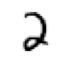

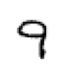

In [ ]:
show_image(tensors_dict[2][1])
show_image(tensors_dict[9][1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel.

In [ ]:
# Calculate the stacked tensor for each of the digit and store that tensor in a dictionary index by digit
stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have around 6,000 images for each digit, each image of size 28×28 pixels. 

In [ ]:
print('Shapes of image tensor for each digit:')
for digit, img_tensor in stacked_tensors_dict.items():
    print('   ', digit, ': ', stacked_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
    0 :  torch.Size([5923, 28, 28])
    1 :  torch.Size([6742, 28, 28])
    2 :  torch.Size([5958, 28, 28])
    3 :  torch.Size([6131, 28, 28])
    4 :  torch.Size([5842, 28, 28])
    5 :  torch.Size([5421, 28, 28])
    6 :  torch.Size([5918, 28, 28])
    7 :  torch.Size([6265, 28, 28])
    8 :  torch.Size([5851, 28, 28])
    9 :  torch.Size([5949, 28, 28])


Finally, we can compute what the ideal digit image looks like.or a single image. Here it is:

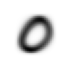

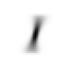

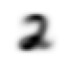

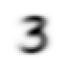

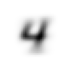

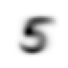

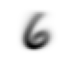

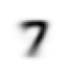

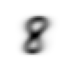

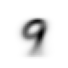

In [ ]:
means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit])

According to this dataset, these are the ideal images for each of the digits

Here's a sample image of one digit:

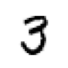

In [ ]:
selected_digit = 3
img = stacked_tensors_dict[selected_digit][2]
show_image(img);

Let's compare again our Mean Absolute Error (MAE) and Mean Square Error (MSE)

In [ ]:
dist_3_mae = (img - means_dict[3]).abs().mean()
dist_3_mse = ((img - means_dict[3])**2).mean().sqrt()
dist_3_mae, dist_3_mse

(tensor(0.1100), tensor(0.1980))

In [ ]:
dist_7_mae = (img - means_dict[7]).abs().mean()
dist_7_mse = ((img - means_dict[7])**2).mean().sqrt()
dist_7_mae, dist_7_mse

(tensor(0.1541), tensor(0.2974))

Let's visualize what these distances mean:

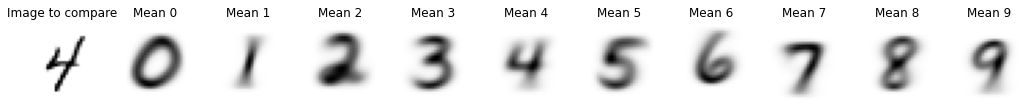


Simple Difference:


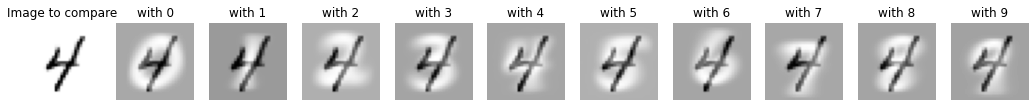


MAE - Mean Absolute Error:


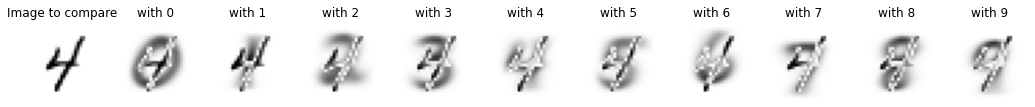


MSE - Mean Squared Error:


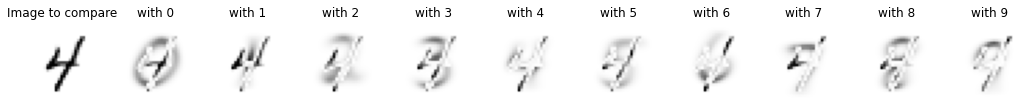

In [ ]:
digit = 4
img = stacked_tensors_dict[digit][10]

fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image(means_dict[i], title=f"Mean {i}", ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nSimple Difference:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nMAE - Mean Absolute Error:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]).abs(), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nMSE - Mean Squared Error:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]).square(), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [ ]:
F.l1_loss(img.float(),means_dict[7]), F.mse_loss(img, means_dict[7]).sqrt()  

(tensor(0.1161), tensor(0.2299))

So, is our baseline model any good? To quantify this, we must define a metric.

### Create validation set

In [ ]:
valid_tensors_dict = {}

for digit, tnrs in stacked_tensors_dict.items():
    valid_tensors_dict[digit] = torch.stack([tensor(Image.open(o)) 
                                             for o in (path/'testing'/f"{digit}").ls()])
    valid_tensors_dict[digit] = valid_tensors_dict[digit].float()/255
    print('shape for',digit, ':', valid_tensors_dict[digit].shape)

shape for 0 : torch.Size([980, 28, 28])
shape for 1 : torch.Size([1135, 28, 28])
shape for 2 : torch.Size([1032, 28, 28])
shape for 3 : torch.Size([1010, 28, 28])
shape for 4 : torch.Size([982, 28, 28])
shape for 5 : torch.Size([892, 28, 28])
shape for 6 : torch.Size([958, 28, 28])
shape for 7 : torch.Size([1028, 28, 28])
shape for 8 : torch.Size([974, 28, 28])
shape for 9 : torch.Size([1009, 28, 28])


It's good to get in the habit of checking shapes as you go. Here we see 10 tensors, each representing one digit validation set of about 1,000 images of size 28×28. Total number of validation images is 10,000.

In [ ]:
print('Shapes of image tensor for each digit:')
for digit, tnrs in valid_tensors_dict.items():
    print(' shape for',digit, ':', valid_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
 shape for 0 : torch.Size([980, 28, 28])
 shape for 1 : torch.Size([1135, 28, 28])
 shape for 2 : torch.Size([1032, 28, 28])
 shape for 3 : torch.Size([1010, 28, 28])
 shape for 4 : torch.Size([982, 28, 28])
 shape for 5 : torch.Size([892, 28, 28])
 shape for 6 : torch.Size([958, 28, 28])
 shape for 7 : torch.Size([1028, 28, 28])
 shape for 8 : torch.Size([974, 28, 28])
 shape for 9 : torch.Size([1009, 28, 28])


### Loss - Metric

Code for this approach:

1. We keep the same distance as before, that is MAE:

In [ ]:
def mnist_distance(a, b): 
    return (a - b).abs().mean((-1, -2))

mnist_distance(img, means_dict[7])

tensor(0.1161)

2. We compute the distance to each digit mean

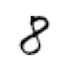

Distance between image and 0 is 0.16634075343608856 
Distance between image and 1 is 0.11421868950128555 
Distance between image and 2 is 0.1429552286863327 
Distance between image and 3 is 0.12959136068820953 
Distance between image and 4 is 0.14074993133544922 
Distance between image and 5 is 0.1344362497329712 
Distance between image and 6 is 0.15652191638946533 
Distance between image and 7 is 0.14457924664020538 
Distance between image and 8 is 0.11600539088249207 
Distance between image and 9 is 0.13203886151313782 


In [ ]:
# Select an image to compate
img_tnsr = valid_tensors_dict[8][559]
show_image(img_tnsr)
plt.show()

for i in range(10):
    print(f"Distance between image and {i} is {mnist_distance(img_tnsr, means_dict[i])} ")

The smallest distance should represent the correct digit. In this case it is correct.

With broadcasting, we also can apply the distance to all the images of one class/digit at the same time. `mnist_distance` should return a tensor with the distances for all the images in the batch.

In [ ]:
# Select a batch with all the images representing one digit
img_tnsr = stacked_tensors_dict[8]

distances = mnist_distance(img_tnsr, means_dict[7])
display(distances.shape)
display(distances)

torch.Size([5851])

tensor([0.1501, 0.1984, 0.1541,  ..., 0.1339, 0.1280, 0.1585])

In [ ]:
# Show distances to all the digits
img_tnsr = stacked_tensors_dict[8]

for i in range(10):
    display(mnist_distance(img_tnsr, means_dict[i]))

tensor([0.1795, 0.2126, 0.1797,  ..., 0.1697, 0.1837, 0.1942])

tensor([0.1039, 0.2042, 0.0930,  ..., 0.1016, 0.0990, 0.1375])

tensor([0.1480, 0.2038, 0.1472,  ..., 0.1283, 0.1469, 0.1563])

tensor([0.1456, 0.1777, 0.1394,  ..., 0.1344, 0.1268, 0.1538])

tensor([0.1559, 0.2038, 0.1607,  ..., 0.1249, 0.1370, 0.1435])

tensor([0.1481, 0.1930, 0.1450,  ..., 0.1308, 0.1336, 0.1525])

tensor([0.1612, 0.1939, 0.1614,  ..., 0.1305, 0.1458, 0.1656])

tensor([0.1501, 0.1984, 0.1541,  ..., 0.1339, 0.1280, 0.1585])

tensor([0.1197, 0.1959, 0.1252,  ..., 0.1110, 0.1156, 0.1399])

tensor([0.1483, 0.1949, 0.1511,  ..., 0.1262, 0.1202, 0.1497])

Let's see how are can compute all the distances from one image tensor batch to each of the digit means in a few operations only. 

1. Let's see what we have to start with:
    - we start from a batch of image tensors `image_tensor_batch` of shape `(nbr_img, 28, 28)`
    - `mnist_distance(image_tensor_batch)` returns a tensor of shape `(nbr_img)`

In [ ]:
img_batch_tnsr = stacked_tensors_dict[8]
print('Shape of batch_tnsr:', img_batch_tnsr.shape)

distances = mnist_distance(img_tnsr, means_dict[0])
print('Shape of distances: ', distances.shape)

Shape of batch_tnsr: torch.Size([5851, 28, 28])
Shape of distances:  torch.Size([5851])


2. Now we want to have all distances for all digits in a dimension-2 tensor of shape `(nbr of images, 10)`. 

In [ ]:
distances = torch.stack([mnist_distance(img_tnsr, m) for m in means_dict.values()], dim=1)
display(distances)
distances.shape

tensor([[0.1795, 0.1039, 0.1480,  ..., 0.1501, 0.1197, 0.1483],
        [0.2126, 0.2042, 0.2038,  ..., 0.1984, 0.1959, 0.1949],
        [0.1797, 0.0930, 0.1472,  ..., 0.1541, 0.1252, 0.1511],
        ...,
        [0.1697, 0.1016, 0.1283,  ..., 0.1339, 0.1110, 0.1262],
        [0.1837, 0.0990, 0.1469,  ..., 0.1280, 0.1156, 0.1202],
        [0.1942, 0.1375, 0.1563,  ..., 0.1585, 0.1399, 0.1497]])

torch.Size([5851, 10])

"decrypting" code above: `torch.stack([mnist_distance(img_tnsr, m) for m in means_dict.values()], dim=1)`
- Signature of stack: `torch.stack(tensors, dim=0)` [doc](https://pytorch.org/docs/stable/generated/torch.stack.html):
    - `tensors` is a sequence of tensors to concatenate, for instance a list of tensors
    - `dim` is the dimension to insert. Has to be between 0 and the number of dimensions of concatenated, In our case, `dim` is 1 as we want to stack the 10 values for each images. You can try other values and see what it gives.
- `[mnist_distance(img_tnsr, m) for m in means_dict.values()]`:
    - list comprehension to get a list of the 10 distances, one for each digit. Remember that means_dict keeps the ten mean images reporesenting the "ideal" difit. The list comprehension is equivalent to:
    ```python
        tensor_list = []
        for mean in means_dict.values():
            tensor_list.append(mnist_distance(img_tnsr, m))
    ```

The code is passing a list of 10 dimension-1 tensors (shape = `(number of images in the batch)`) to `torch.stack`, to create a dimension-2 tensor of shape `(number of images in the batch, 10)`

Now we have a tensor `distances` with the distance of each image to the ten means. We can index it to get the distances of any image to the ten means.

In [ ]:
distances[120:125, :]

tensor([[0.1680, 0.1831, 0.1666, 0.1545, 0.1572, 0.1537, 0.1583, 0.1848, 0.1462, 0.1656],
        [0.1888, 0.1888, 0.1770, 0.1895, 0.1614, 0.1828, 0.1675, 0.1957, 0.1638, 0.1754],
        [0.1686, 0.1799, 0.1772, 0.1616, 0.1734, 0.1523, 0.1580, 0.1956, 0.1547, 0.1768],
        [0.1796, 0.1059, 0.1646, 0.1448, 0.1495, 0.1309, 0.1498, 0.1442, 0.1367, 0.1318],
        [0.1684, 0.1696, 0.1688, 0.1595, 0.1498, 0.1495, 0.1552, 0.1718, 0.1316, 0.1451]])

3. Select the class/digit for each image in the batch: pick the minimum distance. We will use the method tensor `argmin()` to pick the index with minimum distance, which is the digit corresponding to the minumum distance and therefore our class as we defined it in our approach.

> See how `argmin` works with a single image. We pick one image tensor and show it. We also pick the corresponding distances to the ten digit, i.e. a tensor of shape (10). `argmin()` returns the index of the minimum distance, in this case 8, which corresponds to digit 8.

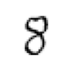

tensor([0.1650, 0.1222, 0.1467, 0.1261, 0.1344, 0.1259, 0.1477, 0.1398, 0.1143, 0.1293])

tensor(0.1143)

In [ ]:
img_nbr = 25
show_image(stacked_tensors_dict[8][img_nbr])
plt.show()

distances_for_one_img = distances[img_nbr]
display(distances_for_one_img)
distances_for_one_img.argmin()
distances_for_one_img[8]

When we apply to a batch of images, we need to tell pytorch along which direction the minimum must be seeked. In our case `dim=1`.  It returns a tensor of dimension 1, with shape = `(nbr_img)`

In [ ]:
digits = distances.argmin(dim=1)
digits.shape

torch.Size([5851])

```
argmin(input, dim, keepdim=False) -> LongTensor

Returns the indices of the minimum values of a tensor across a dimension.

This is the second value returned by :meth:`torch.min`. See its
documentation for the exact semantics of this method.

Args:
    input (Tensor): the input tensor.
    dim (int): the dimension to reduce. If ``None``, the argmin of the flattened input is returned.
    keepdim (bool): whether the output tensor has :attr:`dim` retained or not. Ignored if ``dim=None``.
```

Using `argmin()` allows us to compute the mimimun for all images, in one step, and with no Python loop.

### Pixel Similarity Classifier

Now we can build our classifier as a function `evaluate_digit` to which we pass an image tensor or a batch of image tensors and which will return a class/digit

In [ ]:
def evaluate_digit(x): 
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
    distances = torch.stack([mnist_distance(x, m) for m in means_dict.values()], dim=1)
    return distances.argmin(dim=1)

>Note: we unsqueeze the tensor when a single image is given instead of a batch, because we expect a batch. Unsqueezing is like translforming a single image into a batch with a single image:
```python
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
```

See the difference below

In [ ]:
img.shape, img.unsqueeze(dim=0).shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

Let's test our classifier with a single image:

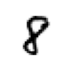

tensor([8])

In [ ]:
tnsr = stacked_tensors_dict[8][58]
show_image(tnsr)
plt.show()

evaluate_digit(tnsr)

Let's test our classifier with a small image batch:

In [ ]:
tnsr = stacked_tensors_dict[8][58:87]
print('Nbr images: ', tnsr.shape[0])

evaluate_digit(tnsr)

Nbr images:  29


tensor([8, 8, 1, 1, 9, 1, 8, 9, 1, 8, 1, 1, 8, 8, 1, 9, 9, 9, 1, 8, 3, 8, 1, 1, 8, 1, 8, 1, 8])

We can see that the model is not that great ! Some images are correctly evaluated and some are not.

### Evaluation of the classifier
Let's compute the accuracy for the train and the validation set for each class/digit
1. For each class, we evaluate the digit for the full dataset (training and validation)
2. We compute how many are correct and how many are not correct

In [ ]:
# One class at the time
digit = 5
tnsr = stacked_tensors_dict[digit]
preds = evaluate_digit(tnsr) 
correct = torch.eq(preds, digit).sum()
incorrect = torch.ne(preds, digit).sum()
correct.item(), incorrect.item(), (correct / preds.shape[0]).item()

(1627, 3794, 0.30012911558151245)

In [ ]:
# All digits for training set
for digit in range(10):
    tnsr = stacked_tensors_dict[digit]
    preds = evaluate_digit(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8141
Accuracy for 1: 0.9981
Accuracy for 2: 0.4329
Accuracy for 3: 0.5836
Accuracy for 4: 0.6648
Accuracy for 5: 0.3001
Accuracy for 6: 0.7454
Accuracy for 7: 0.7778
Accuracy for 8: 0.3958
Accuracy for 9: 0.7163


In [ ]:
# All digits for validation set
for digit in range(10):
    tnsr = valid_tensors_dict[digit]
    preds = evaluate_digit(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8153
Accuracy for 1: 0.9982
Accuracy for 2: 0.4234
Accuracy for 3: 0.6089
Accuracy for 4: 0.6680
Accuracy for 5: 0.3262
Accuracy for 6: 0.7871
Accuracy for 7: 0.7646
Accuracy for 8: 0.4425
Accuracy for 9: 0.7760


Although this is not awfull, the performance varies a lot for each of the digit. 0 and 1 are well classified byt 5 and 8 are not, for example.

Can we do better if we use another metric? We uses MAE, let's do the same but using RMSE:

In [ ]:
# Define a new loss/distance function: mnist_rmse
def mnist_rmse(a, b):
    return ((a - b) ** 2 ).mean((-1, -2)).sqrt()

# Our new classifier will use rmse to compute the distances and pick the minimum
def evaluate_digit_rmse(x): 
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
    distances = torch.stack([mnist_rmse(x, m) for m in means_dict.values()], dim=1)
    return distances.argmin(dim=1)

Now we can evaluate the performance of this new classifer with the validation set

In [ ]:
# All digits for validation set
for digit in range(10):
    tnsr = valid_tensors_dict[digit]
    preds = evaluate_digit_rmse(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8959
Accuracy for 1: 0.9621
Accuracy for 2: 0.7568
Accuracy for 3: 0.8059
Accuracy for 4: 0.8259
Accuracy for 5: 0.6861
Accuracy for 6: 0.8633
Accuracy for 7: 0.8327
Accuracy for 8: 0.7372
Accuracy for 9: 0.8067


We see that the accuracy increases for almost all the digits. 

The base line is not bad, but all in all, it still shows some relativaly low accuracy compared to real model.

## Stochastic Gradient Descent (SGD)

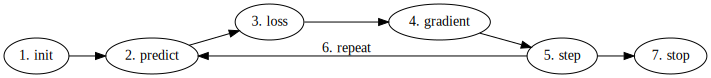

In [ ]:
gv('''
"1. init"->"2. predict"->"3. loss"->"4. gradient"->"5. step"->"7. stop"
"5. step"->"2. predict"[label="6. repeat"]
''')

Steps that we are going to require, to turn a function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

#### Prepare datasets and dataloaders

`train_x` is the set of independant variables (inputs), that is our images. We create  `train_x` tensor by concatenating all the tensors for each digit.

In [ ]:
train_x = torch.cat([stacked_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

In [ ]:
train_x.shape

torch.Size([60000, 784])

As expected, it is a set of 60,000 images represented as a flat one dimension vector of shape 28 x 28 = 784

We need a label for each image, 0 to 9, depending on the digit the image represent. It is not as simple as for the basic MNIST case, as we have more than two classes and the number of images in each class is not equal. There is probably an easier way than the one below !

In [ ]:
# Returns a list of 10 sublists, where each sublist consists of as many times digit as the number of image in the category
l = [ [i] * stacked_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == train_x.shape[0] 

In [ ]:
# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == train_x.shape[0]

train_y = torch.tensor(label_list).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

The shapes of `train_x` and `train_y` are as expected

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [ ]:
from random import shuffle

dset = list(zip(train_x,train_y))

# Shuffle the dset so that digits are mixed
shuffle(dset)


x, y = dset[0]
x.shape,y

(torch.Size([784]), tensor([5]))

Now we do the same for the validation sets

In [ ]:
valid_x = torch.cat([valid_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * valid_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == valid_x.shape[0] 
print(valid_x.shape)

# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == valid_x.shape[0]

valid_y = torch.tensor(label_list).unsqueeze(1)
print(valid_y.shape)

valid_dset = list(zip(valid_x,valid_y))

torch.Size([10000, 784])
torch.Size([10000, 1])


Datasets are ready. Now we prepare the dataloaders to feed the training loop.

In [ ]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=5)

#### Define the model architecture and parameters

Model is defined by creating functions to compute each of the 7 steps listed above

##### Parameters

In our model, we need to evaluate the distance from one image (input) to each of the possible classes (0 - 9). So we need to predict 10 values, out of which we will pick the minimum value to predict the correpsonding digit.

In effect,**y** in **y=Wx+b** represents the `distances` between the image **x** and each of the digits. **y** is therefore a vector of shape `(10)`. The prediction is computed from an image **x** which is a vector of shape `(784)`. Therefore **W** must be of shape `(784, 10)`. And **b** must be of the same shape as the output, that is shape `(10)`.

<img src="https://raw.githubusercontent.com/vtecftwy/fastbook/master/images/img_mnist_full_linear_layer.png" height="400px" />


Define a function to create random parameters, and then create **W** and **b** with the correct shapes

In [ ]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 10))
bias = init_params(10)

weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

##### Define functions to calculate the predictions. 

The output of the linear layer is a distance. If we apply `softmax`, we get a sort of probability (sum of values = 1), which is what we want. Also, we can use `softmax` or `log_sofmax`. But it is useful to use `log_softmax` for several reasons, including the fact that larger errors are more penalized then small errors and the fact that it allows some computation stability in the network (see [here](https://deepdatascience.wordpress.com/2020/02/27/log-softmax-vs-softmax/)). 

See pytorch documentation: [`softmax`](https://pytorch.org/docs/stable/nn.functional.html?highlight=softmax#softmax) and [`log_softmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=softmax#logsoftmax)

Note: **`torch.nn.functional`** can be shorted as **`F`**

In [ ]:
def linear(xb):
    outputs =  xb @ weights + bias
    probs = F.log_softmax(outputs, dim=1)
    return probs

def evaluate_preds(xb):
    probs = linear(xb)
    return probs.argmax(dim=1).unsqueeze(dim=1)

##### Define a function to calculate the loss

As we have 10 classes, the loss function should be **cross entropy**. In PyTorch, there is a function `cross_entropy` ([`doc`](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy)) and a layer `CrossEntropyLoss`([`doc`](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy)). It happens to be a combination of `log_softmax` ([`doc`](https://pytorch.org/docs/stable/nn.functional.html#log-softmax)), which we have applied already in the linear layer, and `nll_loss` ([`doc`](https://pytorch.org/docs/stable/nn.functional.html#nll-loss)). `nll_loss` stands for *negative log likelihood loss*

So, let's apply `nll_loss` to the output of linear layer.

More on negative log likelihood loss [here](https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6) and cross entropy [here](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)

Other links: 
- https://glassboxmedicine.com/2019/12/07/connections-log-likelihood-cross-entropy-kl-divergence-logistic-regression-and-neural-networks/
- https://gombru.github.io/2018/05/23/cross_entropy_loss/

In [ ]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    # print(loss)
    loss.backward()

In [ ]:
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# probs = linear(xb)
# display(probs.shape)
# evaluate_preds(xb)
# display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, linear)

##### Define a function performing one step/one epoch

In [ ]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [ ]:
def batch_accuracy(xb, yb):
    """Determines how many of the predictions are actually correct"""
    accuracy = torch.eq(xb, yb).sum() / xb.shape[0]
    return accuracy

In [ ]:
# preds.unsqueeze(dim=1)

In [ ]:
def validate_epoch(model):
    """Collects the accuracy from each element in the dataloader and displays it"""
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

#### Bringing it all together and run training loop

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(10)

lr = 1
params = weights, bias

train_epoch(linear, lr, params)

train_epoch(linear, lr, params)
validate_epoch(evaluate_preds)

0.873

Run 20 epochs and see the accuracy for each epoch

In [ ]:
n_epochs = 20
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')

0:0.8829 1:0.8866 2:0.8921 3:0.8935 4:0.8966 5:0.8980 6:0.8988 7:0.8995 8:0.9016 9:0.9031 10:0.9047 11:0.9059 12:0.9080 13:0.9090 14:0.9091 15:0.9099 16:0.9105 17:0.9110 18:0.9112 19:0.9112 

Run another 20/200/2000 epochs several times and see the evolution of the accuracy

In [ ]:
n_epochs = 20
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')

0:0.9118 1:0.9122 2:0.9127 3:0.9133 4:0.9142 5:0.9149 6:0.9150 7:0.9154 8:0.9151 9:0.9155 10:0.9159 11:0.9158 12:0.9163 13:0.9167 14:0.9166 15:0.9168 16:0.9172 17:0.9174 18:0.9175 19:0.9174 

In [ ]:
n_epochs = 20
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')

0:0.9177 1:0.9181 2:0.9187 3:0.9190 4:0.9192 5:0.9191 6:0.9190 7:0.9194 8:0.9200 9:0.9201 10:0.9201 11:0.9202 12:0.9201 13:0.9202 14:0.9204 15:0.9205 16:0.9204 17:0.9204 18:0.9204 19:0.9202 

In [ ]:
n_epochs = 200
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')
print(validate_epoch(evaluate_preds))

0:0.9198 10:0.9201 20:0.9212 30:0.9219 40:0.9222 50:0.9218 60:0.9222 70:0.9220 80:0.9220 90:0.9222 100:0.9220 110:0.9216 120:0.9218 130:0.9217 140:0.9218 150:0.9221 160:0.9223 170:0.9221 180:0.9220 190:0.9219 0.922


In [ ]:
n_epochs = 200
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')
print(validate_epoch(evaluate_preds))

0:0.9221 10:0.9224 20:0.9226 30:0.9227 40:0.9227 50:0.9229 60:0.9229 70:0.9231 80:0.9232 90:0.9233 100:0.9234 110:0.9232 120:0.9231 130:0.9229 140:0.9228 150:0.9227 160:0.9228 170:0.9228 180:0.9228 190:0.9229 0.9229


In [ ]:
n_epochs = 2000
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%100 == 0:
        print(f"{i}:{validate_epoch(evaluate_preds):1.4f}", end=' ')
print(validate_epoch(evaluate_preds))

0:0.9220 100:0.9218 200:0.9222 300:0.9218 400:0.9215 500:0.9212 600:0.9215 700:0.9219 800:0.9218 900:0.9216 1000:0.9214 1100:0.9216 1200:0.9216 1300:0.9216 1400:0.9217 1500:0.9216 1600:0.9217 1700:0.9215 1800:0.9215 1900:0.9212 0.9209


In [ ]:
print(validate_epoch(evaluate_preds))

0.9209


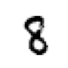

tensor([[8]])

In [ ]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
evaluate_preds(img.view(28*28).unsqueeze(dim=0))

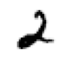

tensor([[2]])

In [ ]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()
evaluate_preds(img.view(28*28).unsqueeze(dim=0))

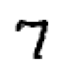

tensor([[7]])

In [ ]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()
evaluate_preds(img.view(28*28).unsqueeze(dim=0))

## Improve model by introducing ReLu and two layers

In [ ]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

w1 = init_params((28*28, 100))
b1 = init_params(100)

w2 = init_params((100, 10))
b2 = init_params(10)

w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 100]),
 torch.Size([100]),
 torch.Size([100, 10]),
 torch.Size([10]))

##### Define functions to calculate the predictions

In [ ]:
activ1 = nn.ReLU()

def linear1(xb):
    outputs =  xb @ w1 + b1
    return activ1(outputs)

def linear2(xb):
    outputs =  xb @ w2 + b2
    probs = F.log_softmax(outputs, dim=1)
    return probs

def model(xb):
    xb = linear1(xb)
    xb = linear2(xb)
    return xb

def classifier(xb):
    xb = model(xb)
    return xb.argmax(dim=1).unsqueeze(dim=1)

In [ ]:
# # Testing layer by layer
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# display(linear1(xb).shape)
# display(linear2(linear1(xb)).shape)
# display(model(xb))
# classifier(xb)[0:3]

##### Define a function to calculate the loss

In [ ]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    # print(loss)
    loss.backward()

In [ ]:
# # Testing function
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# probs = model(xb)
# display(probs.shape)
# # display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, model)

##### Define a function performing one step/one epoch

In [ ]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [ ]:
#Determines how many of the predictions are actually correct 
def batch_accuracy(xb, yb):
    accuracy = torch.eq(xb, yb).sum() / xb.shape[0]
    return accuracy

In [ ]:
# preds.unsqueeze(dim=1)

In [ ]:
#Collects the accuracy from each element in the dataloader and displays it
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

#### Bringing it all together and run training loop

Create a function to run `n` epochs and display results.

In [ ]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = validate_epoch(classifier)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    print(f"\nLast:{v:1.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'], metric_results['values'])
    return metric_results

Shuffle data, initalize parameters, run one epoch

In [ ]:
shuffle(dset)
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=5)

w1 = init_params((28*28, 100))
b1 = init_params(100)
w2 = init_params((100, 10))
b2 = init_params(10)

lr = 1
params = w1, b1, w2, b2

metric_results = {}
metric_results['epochs'] = [0]
metric_results['values'] = [0]

train_epoch(model, lr, params)
validate_epoch(classifier)

0.7478

  1:0.8242   2:0.8489   3:0.8748   4:0.8843   5:0.8938   6:0.9023   7:0.9064   8:0.9094   9:0.9118  10:0.9146
 11:0.9168  12:0.9178  13:0.9192  14:0.9192  15:0.9199  16:0.9207  17:0.9211  18:0.9225  19:0.9247  20:0.9251

Last:0.9251


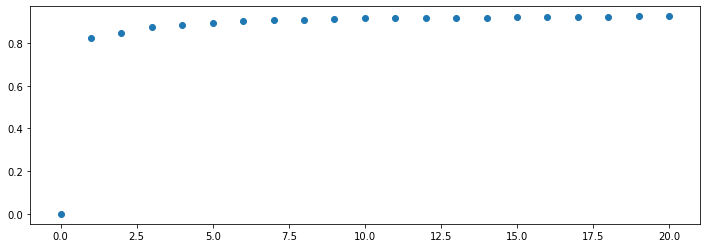

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

 21:0.9257  22:0.9266  23:0.9274  24:0.9292  25:0.9301  26:0.9310  27:0.9309  28:0.9318  29:0.9329  30:0.9336
 31:0.9340  32:0.9342  33:0.9354  34:0.9356  35:0.9362  36:0.9364  37:0.9361  38:0.9375  39:0.9381  40:0.9388

Last:0.9388


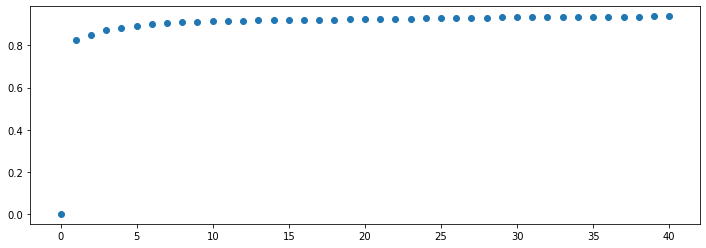

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

 41:0.9384  42:0.9403  43:0.9397  44:0.9403  45:0.9407  46:0.9413  47:0.9419  48:0.9420  49:0.9422  50:0.9419
 51:0.9413  52:0.9419  53:0.9425  54:0.9419  55:0.9418  56:0.9423  57:0.9424  58:0.9426  59:0.9431  60:0.9428

Last:0.9428


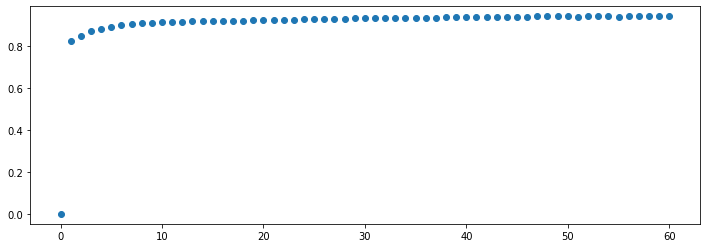

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

 61:0.9431  62:0.9435  63:0.9434  64:0.9434  65:0.9434  66:0.9439  67:0.9448  68:0.9443  69:0.9448  70:0.9449
 71:0.9441  72:0.9454  73:0.9450  74:0.9451  75:0.9450  76:0.9454  77:0.9458  78:0.9458  79:0.9454  80:0.9459
 81:0.9461  82:0.9460  83:0.9461  84:0.9460  85:0.9464  86:0.9465  87:0.9467  88:0.9462  89:0.9469  90:0.9465
 91:0.9469  92:0.9470  93:0.9462  94:0.9462  95:0.9460  96:0.9461  97:0.9467  98:0.9464  99:0.9464 100:0.9463
101:0.9467 102:0.9466 103:0.9469 104:0.9465 105:0.9464 106:0.9464 107:0.9468 108:0.9463 109:0.9463 110:0.9465

Last:0.9465


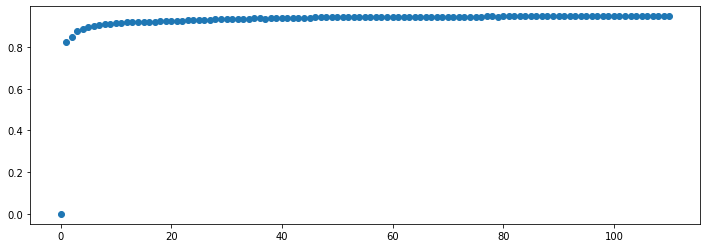

In [ ]:
metric_results = run_n_epochs(model, lr, params, 50)

111:0.9468 112:0.9465 113:0.9466 114:0.9463 115:0.9469 116:0.9474 117:0.9471 118:0.9463 119:0.9471 120:0.9462
121:0.9469 122:0.9469 123:0.9471 124:0.9472 125:0.9476 126:0.9473 127:0.9478 128:0.9473 129:0.9477 130:0.9474
131:0.9476 132:0.9477 133:0.9476 134:0.9476 135:0.9477 136:0.9476 137:0.9479 138:0.9482 139:0.9477 140:0.9475
141:0.9483 142:0.9472 143:0.9474 144:0.9475 145:0.9475 146:0.9478 147:0.9474 148:0.9473 149:0.9474 150:0.9471
151:0.9477 152:0.9477 153:0.9475 154:0.9470 155:0.9475 156:0.9472 157:0.9471 158:0.9466 159:0.9471 160:0.9465

Last:0.9465


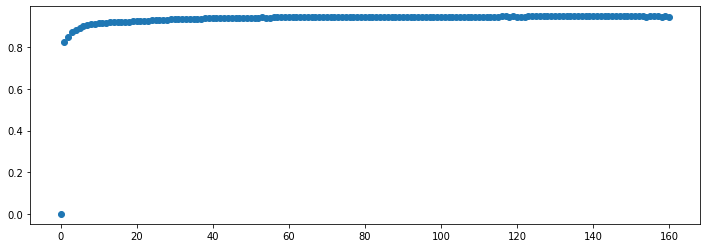

In [ ]:
metric_results = run_n_epochs(model, lr, params, 50)

161:0.9491 162:0.9494 163:0.9492 164:0.9494 165:0.9491 166:0.9493 167:0.9492 168:0.9491 169:0.9493 170:0.9492
171:0.9490 172:0.9493 173:0.9490 174:0.9490 175:0.9490 176:0.9490 177:0.9490 178:0.9489 179:0.9490 180:0.9490
181:0.9490 182:0.9491 183:0.9490 184:0.9490 185:0.9490 186:0.9490 187:0.9490 188:0.9487 189:0.9490 190:0.9489
191:0.9489 192:0.9490 193:0.9488 194:0.9491 195:0.9491 196:0.9489 197:0.9490 198:0.9489 199:0.9489 200:0.9490
201:0.9488 202:0.9490 203:0.9490 204:0.9489 205:0.9489 206:0.9494 207:0.9491 208:0.9489 209:0.9491 210:0.9491
211:0.9489 212:0.9493 213:0.9491 214:0.9489 215:0.9489 216:0.9489 217:0.9490 218:0.9490 219:0.9488 220:0.9489
221:0.9491 222:0.9490 223:0.9490 224:0.9490 225:0.9491 226:0.9491 227:0.9493 228:0.9494 229:0.9494 230:0.9496
231:0.9493 232:0.9496 233:0.9494 234:0.9496 235:0.9496 236:0.9497 237:0.9497 238:0.9496 239:0.9496 240:0.9496

Last:0.9496


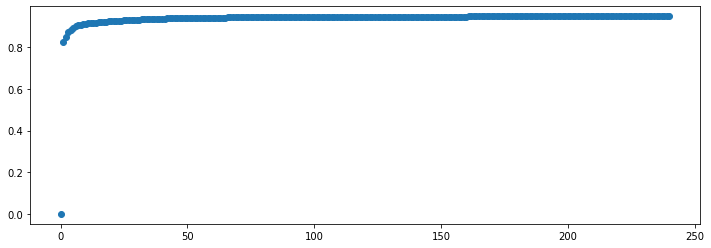

In [ ]:
metric_results = run_n_epochs(model, lr/5, params, 80)

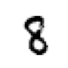

tensor([[8]])

In [ ]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0))

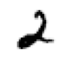

tensor([[2]])

In [ ]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0))

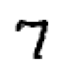

tensor([[7]])

In [ ]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0))

## Improvement 2 model by introducing ReLu and three layers

In [ ]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

w1 = init_params((28*28, 250))
b1 = init_params(250)

w2 = init_params((250, 100))
b2 = init_params(100)

w3 = init_params((100, 10))
b3 = init_params(10)

w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape

(torch.Size([784, 250]),
 torch.Size([250]),
 torch.Size([250, 100]),
 torch.Size([100]),
 torch.Size([100, 10]),
 torch.Size([10]))

##### Define functions to calculate the predictions

In [ ]:
activ1 = nn.ReLU()

def linear1(xb):
    outputs =  xb @ w1 + b1
    return activ1(outputs)

def linear2(xb):
    outputs =  xb @ w2 + b2
    return activ1(outputs)

def linear3(xb):
    """https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.log_softmax"""
    outputs =  xb @ w3 + b3
    probs = torch.log_softmax(outputs, dim=1)
    return probs

def model(xb):
    xb = linear1(xb)
    xb = linear2(xb)
    xb = linear3(xb)
    return xb

def classifier(xb):
    xb = model(xb)
    return xb.argmax(dim=1).unsqueeze(dim=1)

In [ ]:
# # Testing layer by layer
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# display(linear1(xb).shape)
# display(linear2(linear1(xb)).shape)
# display(linear3(linear2(linear1(xb))).shape)
# display(model(xb))
# classifier(xb)[0:3]

##### Define a function to calculate the loss

In [ ]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    # print(loss)
    loss.backward()

In [ ]:
# # Testing function
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# probs = model(xb)
# display(probs.shape)
# # display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, model)

##### Define a function performing one step/one epoch

In [ ]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [ ]:
#Determines how many of the predictions are actually correct 
def batch_accuracy(xb, yb):
    accuracy = torch.eq(xb, yb).sum() / xb.shape[0]
    return accuracy

In [ ]:
# preds.unsqueeze(dim=1)

In [ ]:
#Collects the accuracy from each element in the dataloader and displays it
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

#### Bringing it all together and run training loop

Create a function to run `n` epochs and display results.

In [ ]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = validate_epoch(classifier)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    print(f"\nLast:{v:1.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'], metric_results['values'])
    return metric_results

Shuffle data, initalize parameters, run one epoch

In [ ]:
shuffle(dset)
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=5)

w1 = init_params((28*28, 250))
b1 = init_params(250)
w2 = init_params((250, 100))
b2 = init_params(100)
w3 = init_params((100, 10))
b3 = init_params(10)

lr = 1
params = w1, b1, w2, b2

metric_results = {}
metric_results['epochs'] = [0]
metric_results['values'] = [0]

train_epoch(model, lr, params)
validate_epoch(classifier)

0.1405

 41:0.5276  42:0.4623  43:0.5463  44:0.5656  45:0.5794  46:0.5963  47:0.5719  48:0.5514  49:0.5550  50:0.6071
 51:0.5922  52:0.5620  53:0.5574  54:0.5608  55:0.5621  56:0.5556  57:0.5554  58:0.5489  59:0.5433  60:0.5584

Last:0.5584


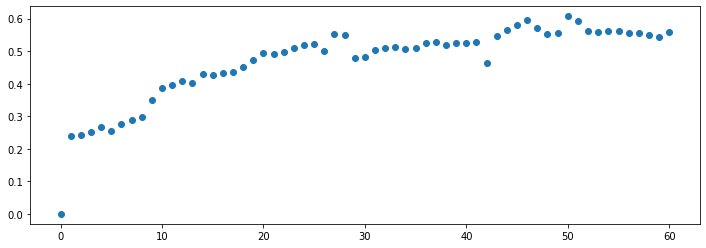

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

 61:0.5776  62:0.6114  63:0.6349  64:0.6239  65:0.6339  66:0.6354  67:0.6473  68:0.6362  69:0.6390  70:0.6365
 71:0.6507  72:0.6403  73:0.6547  74:0.6600  75:0.6387  76:0.6414  77:0.6537  78:0.6538  79:0.6526  80:0.6629

Last:0.6629


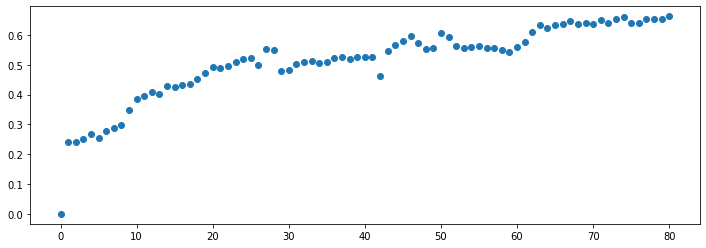

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

 81:0.6751  82:0.6614  83:0.6821  84:0.6734  85:0.6711  86:0.6318  87:0.6844  88:0.7104  89:0.6205  90:0.7080
 91:0.6939  92:0.7033  93:0.7162  94:0.7303  95:0.7242  96:0.7249  97:0.7397  98:0.7038  99:0.7109 100:0.7328

Last:0.7328


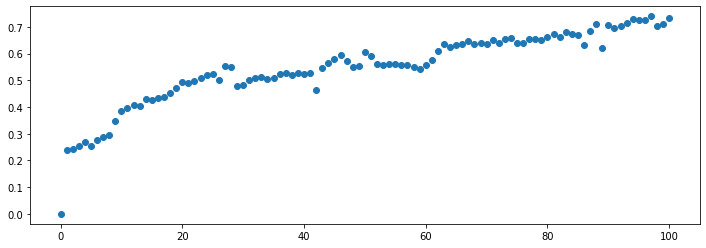

In [ ]:
metric_results = run_n_epochs(model, lr, params, 20)

Adjust the learning rate to have slower learning from here

101:0.7421 102:0.7544 103:0.7438 104:0.7495 105:0.7591 106:0.7576 107:0.7565 108:0.7523 109:0.7633 110:0.7627
111:0.7639 112:0.7670 113:0.7717 114:0.7647 115:0.7663 116:0.7738 117:0.7742 118:0.7714 119:0.7662 120:0.7785

Last:0.7785


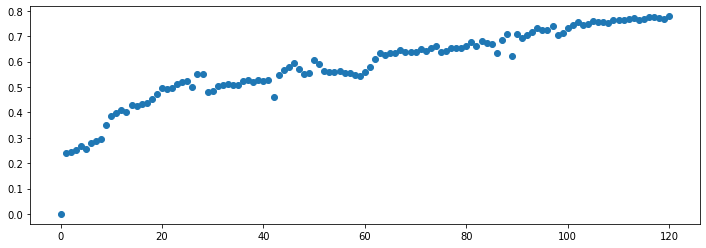

In [ ]:
metric_results = run_n_epochs(model, lr/2, params, 20)

121:0.7759 122:0.7813 123:0.7877 124:0.7833 125:0.7767 126:0.7742 127:0.7856 128:0.7816 129:0.7883 130:0.7797
131:0.7811 132:0.7834 133:0.7836 134:0.7822 135:0.7912 136:0.7840 137:0.7761 138:0.7826 139:0.7847 140:0.7925

Last:0.7925


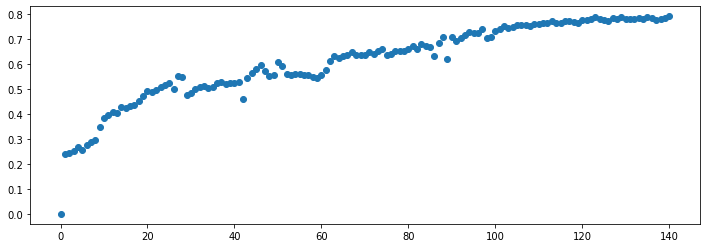

In [ ]:
metric_results = run_n_epochs(model, lr/2, params, 20)

141:0.7785 142:0.7832 143:0.7870 144:0.7887 145:0.7927 146:0.7852 147:0.7887 148:0.7910 149:0.7941 150:0.7941
151:0.7903 152:0.7932 153:0.7548 154:0.7958 155:0.7955 156:0.7939 157:0.7968 158:0.7931 159:0.7945 160:0.7974

Last:0.7974


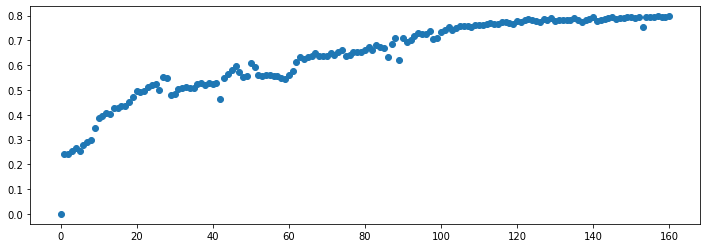

In [ ]:
metric_results = run_n_epochs(model, lr/2, params, 20)

161:0.7925 162:0.7883 163:0.7964 164:0.7991 165:0.7988 166:0.7951 167:0.7971 168:0.7904 169:0.7880 170:0.7973
171:0.7934 172:0.7990 173:0.8008 174:0.7864 175:0.7973 176:0.8014 177:0.7873 178:0.7987 179:0.8122 180:0.8303

Last:0.8303


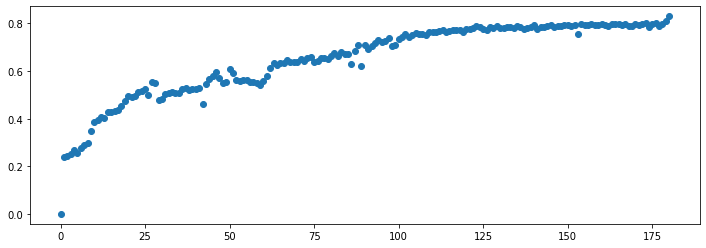

In [ ]:
metric_results = run_n_epochs(model, lr/2, params, 20)

Seems we are bouncing between two values and not improving. Further reduction of the learning rate for even slower training. 

181:0.8544 182:0.8564 183:0.8604 184:0.8614 185:0.8641 186:0.8639 187:0.8666 188:0.8668 189:0.8662 190:0.8673
191:0.8665 192:0.8677 193:0.8671 194:0.8690 195:0.8711 196:0.8700 197:0.8705 198:0.8699 199:0.8713 200:0.8699

Last:0.8699


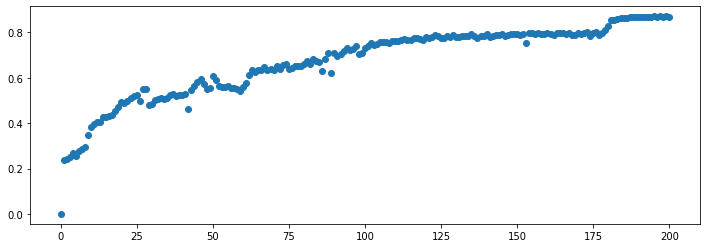

In [ ]:
metric_results = run_n_epochs(model, lr/4, params, 20)

It worked, we managed to pass above 75% accuracy

201:0.8704 202:0.8710 203:0.8711 204:0.8718 205:0.8715 206:0.8707 207:0.8725 208:0.8733 209:0.8721 210:0.8737
211:0.8735 212:0.8737 213:0.8724 214:0.8739 215:0.8725 216:0.8739 217:0.8731 218:0.8727 219:0.8733 220:0.8733
221:0.8715 222:0.8713 223:0.8737 224:0.8707 225:0.8727 226:0.8739 227:0.8719 228:0.8761 229:0.8739 230:0.8742
231:0.8739 232:0.8745 233:0.8745 234:0.8763 235:0.8757 236:0.8777 237:0.8764 238:0.8769 239:0.8774 240:0.8774
241:0.8771 242:0.8762 243:0.8797 244:0.8767 245:0.8786 246:0.8765 247:0.8758 248:0.8777 249:0.8779 250:0.8790

Last:0.8790


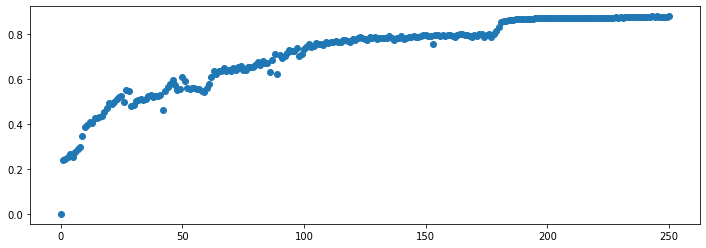

In [ ]:
metric_results = run_n_epochs(model, lr/4, params, 50)

Let's reduce even more the learning rate to try to reach higher accuracy.

260:0.8806 270:0.8809 280:0.8811 290:0.8810 300:0.8814
310:0.8812 320:0.8823 330:0.8826 340:0.8822 350:0.8821 
Last:0.8821


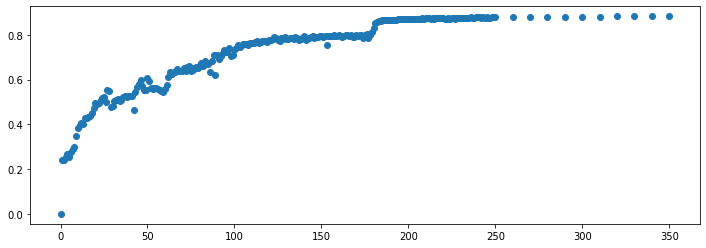

In [ ]:
metric_results = run_n_epochs(model, lr/8, params, 100)

360:0.8839 370:0.8846 380:0.8846 390:0.8845 400:0.8844
410:0.8848 420:0.8843 430:0.8842 440:0.8845 450:0.8852 460:0.8849 470:0.8848 480:0.8855 490:0.8851 500:0.8854
510:0.8851 520:0.8853 530:0.8849 540:0.8845 550:0.8849 560:0.8851 570:0.8848 580:0.8848 590:0.8854 600:0.8846
610:0.8854 620:0.8857 630:0.8860 640:0.8859 650:0.8861 660:0.8865 670:0.8862 680:0.8860 690:0.8859 700:0.8867
710:0.8868 720:0.8866 730:0.8870 740:0.8868 750:0.8870 760:0.8870 770:0.8875 780:0.8872 790:0.8875 800:0.8871
810:0.8869 820:0.8875 830:0.8872 840:0.8869 850:0.8871 
Last:0.8871


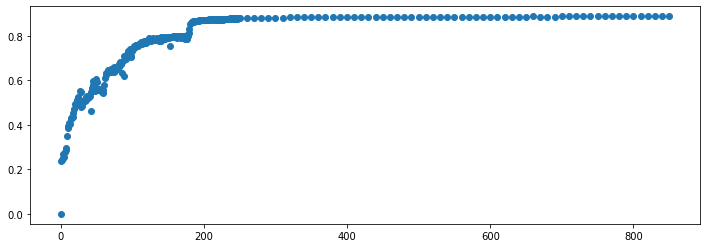

In [ ]:
metric_results = run_n_epochs(model, lr/16, params, 500)